# MNIST CNN solution using a multiprocess procedure on GPU units
Definitions section and data download

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torchsummary import summary
from torchvision import datasets, transforms

Hyperparameters definitions:

In [23]:
num_epochs = 1
num_classes = 10
batch_size = 100
learning_rate = 0.001

Downloading the data set, then images are packed in blocks (or batches) based on the parameter defined above in order to reduce the computation load.

In [27]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=trans, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=trans, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print('Images for training: {}, images for testing: {}'.format(len(train_dataset), len(test_dataset)))

Images for training: 60000, images for testing: 10000


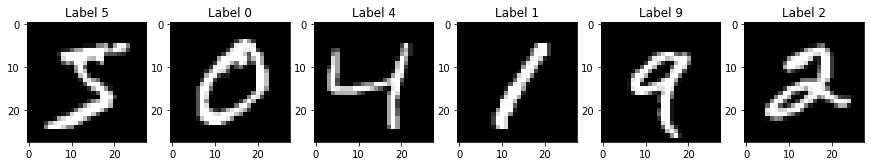

In [4]:
# Figures display example
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1, 6, i+1)
    sample_image, sample_target = train_dataset[i]
    sample_image = torch.squeeze(sample_image).numpy()
    plt.imshow(sample_image, cmap='gray')
    plt.title('Label {}'.format(sample_target))

## CNN model and optimization definition:

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 900)
        self.fc2 = nn.Linear(900, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = ConvNet()
# # device = 'cuda' if torch.cuda.is_available() else 'cpu'
# if torch.cuda.is_available():
#     model.cuda()
# Loss and optimization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
summary(model, (1, 28, 28), 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 28, 28]             832
              ReLU-2            [1, 32, 28, 28]               0
         MaxPool2d-3            [1, 32, 14, 14]               0
            Conv2d-4            [1, 64, 14, 14]          51,264
              ReLU-5            [1, 64, 14, 14]               0
         MaxPool2d-6              [1, 64, 7, 7]               0
           Dropout-7                  [1, 3136]               0
            Linear-8                   [1, 900]       2,823,300
            Linear-9                    [1, 10]           9,010
Total params: 2,884,406
Trainable params: 2,884,406
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.68
Params size (MB): 11.00
Estimated Total Size (MB): 11.68
-------------------------------------

## Training the model and test validation:

In [29]:
# Training the model
total_step, loss_list, acc_list = len(train_loader), [], []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images, labels
        
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking the accuracy
        total = float(labels.size(0))
        _, predicted = torch.max(outputs.data, 1)
        correct = torch.sum(predicted == labels).item()
        acc_list.append(correct / total)

        if (i + 1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

Epoch [1/1], Step [200/600], Loss: 0.0022, Accuracy: 100.00%
Epoch [1/1], Step [400/600], Loss: 0.0061, Accuracy: 100.00%
Epoch [1/1], Step [600/600], Loss: 0.1262, Accuracy: 99.00%


In [155]:
def Integrated_Gradients(x, label_, m = 300):
    xp = torch.ones_like(x) * x[0, 0, 0, 0]
    total = torch.zeros_like(xp)

    for i in range(m):
        otp = (xp + (i/m) * (x - xp))
        otp2 = otp.requires_grad_()
        outputs = model(otp2)
        loss = criterion(outputs, label_)
        loss.backward()
        total += otp2.grad
    
    total = total / m
    result = (x - xp) * total
    
    fig = plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(torch.squeeze(x.detach()).numpy(), cmap='gray')
    plt.title('Original image - Label {}'.format(label_.item()))
        
    plt.subplot(1, 2, 2)
    plt.imshow(torch.squeeze(result.detach()).numpy(), cmap='gray')
    plt.title('Integrated gradients - Label {}'.format(label_.item()))
    plt.colorbar(orientation="vertical")
    
    return result

In [168]:
int_grad_images = []

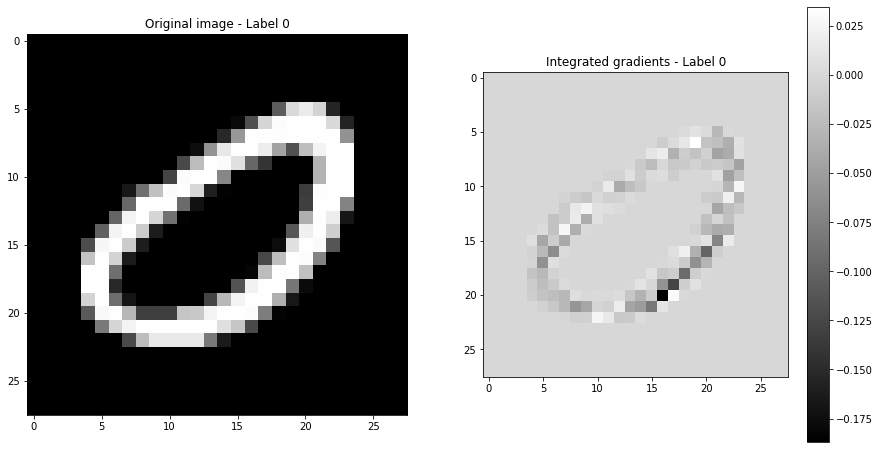

In [169]:
ig = Integrated_Gradients(images[1:2, ].detach(), labels[1:2])
int_grad_images.append(ig)

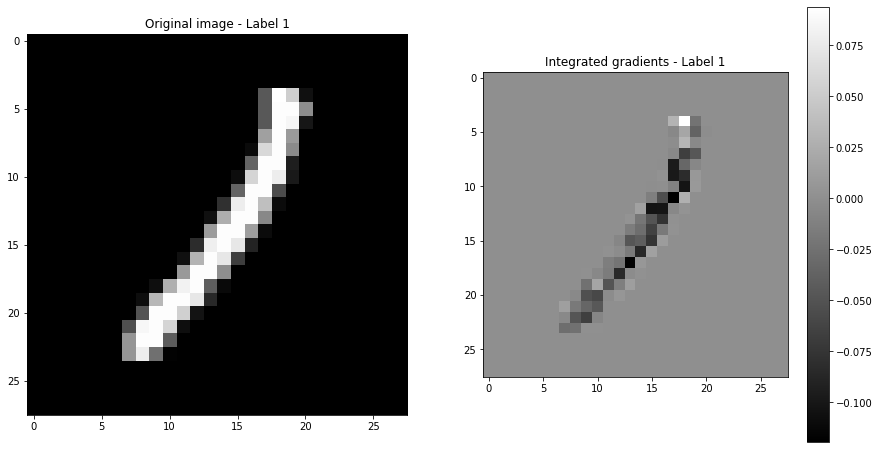

In [170]:
ig = Integrated_Gradients(images[2:3, ].detach(), labels[2:3])
int_grad_images.append(ig)

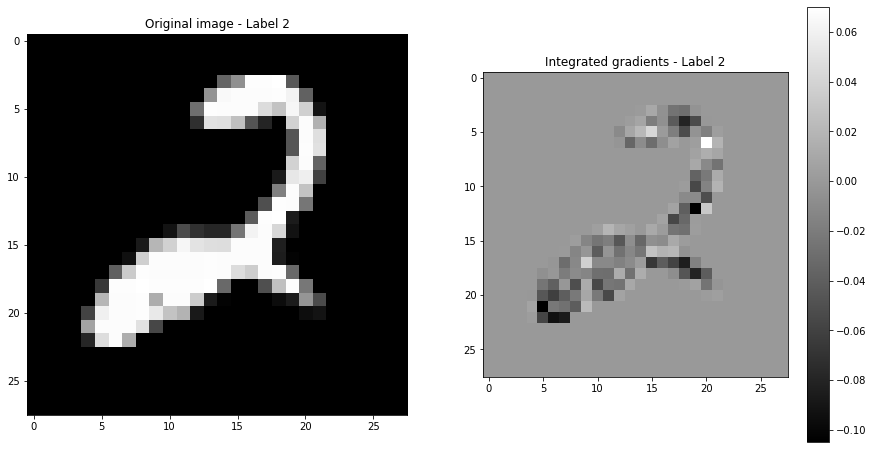

In [171]:
ig = Integrated_Gradients(images[3:4, ].detach(), labels[3:4])
int_grad_images.append(ig)

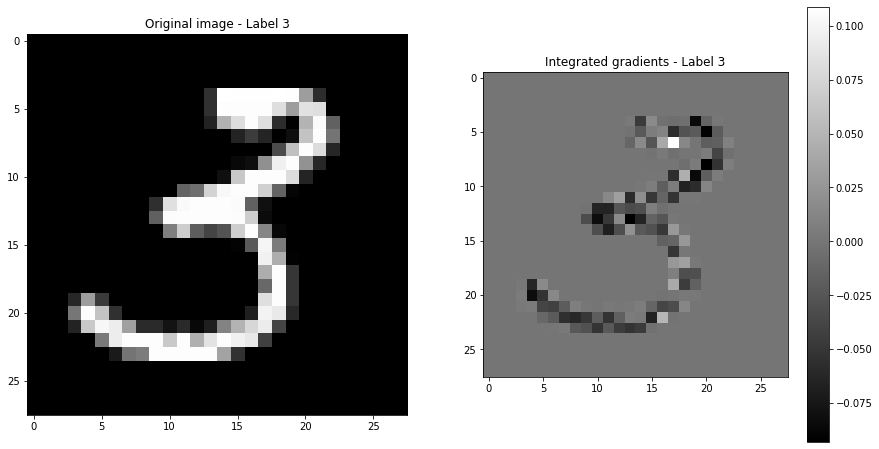

In [172]:
ig = Integrated_Gradients(images[4:5, ].detach(), labels[4:5])
int_grad_images.append(ig)

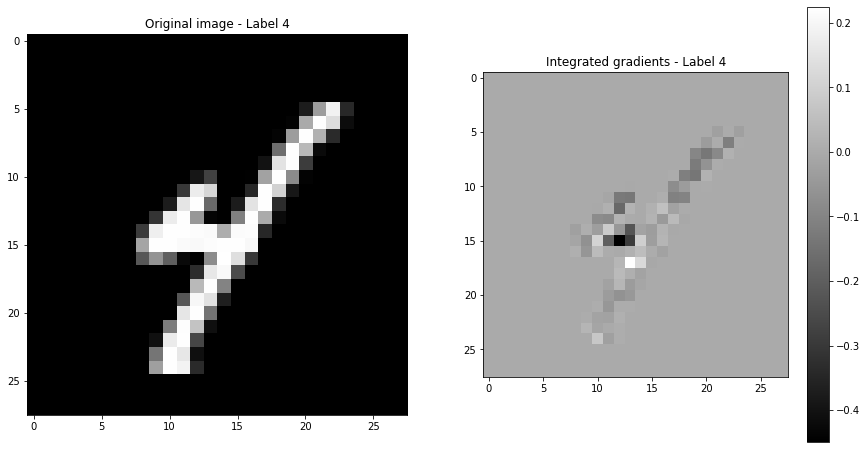

In [173]:
ig = Integrated_Gradients(images[0:1, ].detach(), labels[0:1])
int_grad_images.append(ig)

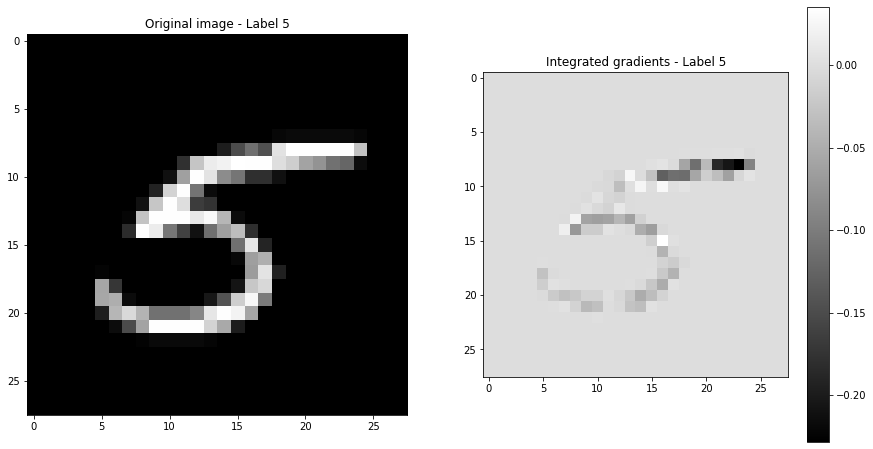

In [174]:
ig = Integrated_Gradients(images[6:7, ].detach(), labels[6:7])
int_grad_images.append(ig)

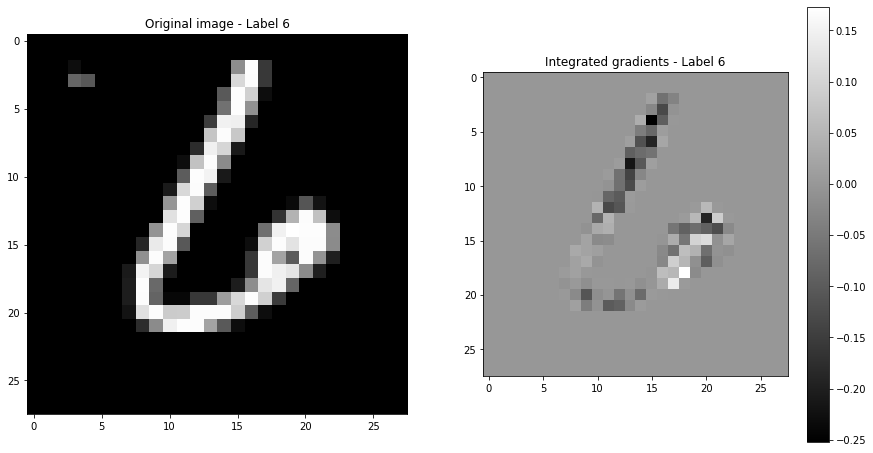

In [175]:
ig = Integrated_Gradients(images[7:8, ].detach(), labels[7:8])
int_grad_images.append(ig)

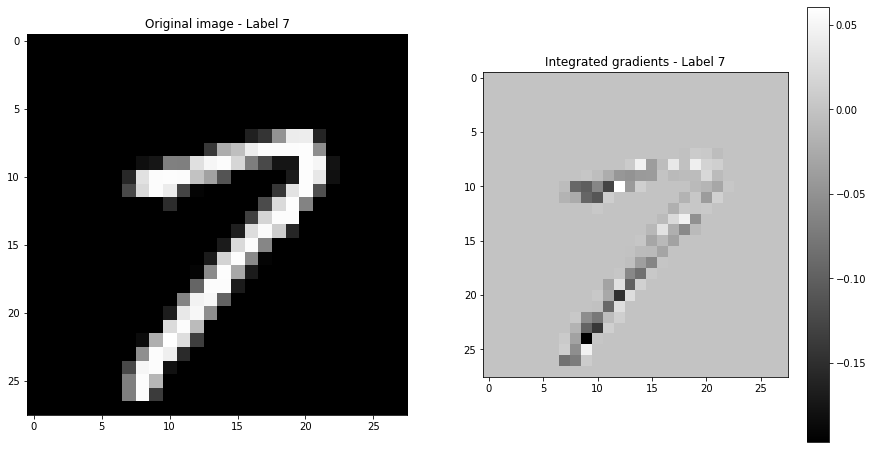

In [176]:
ig = Integrated_Gradients(images[8:9, ].detach(), labels[8:9])
int_grad_images.append(ig)

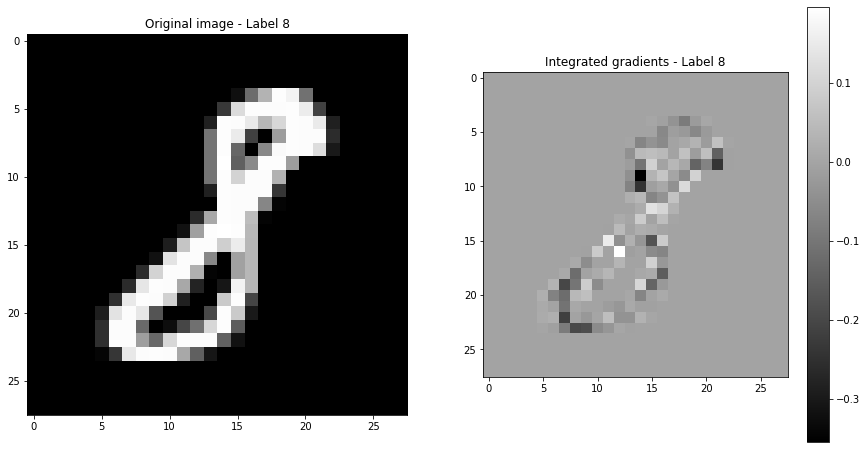

In [177]:
ig = Integrated_Gradients(images[9:10, ].detach(), labels[9:10])
int_grad_images.append(ig)

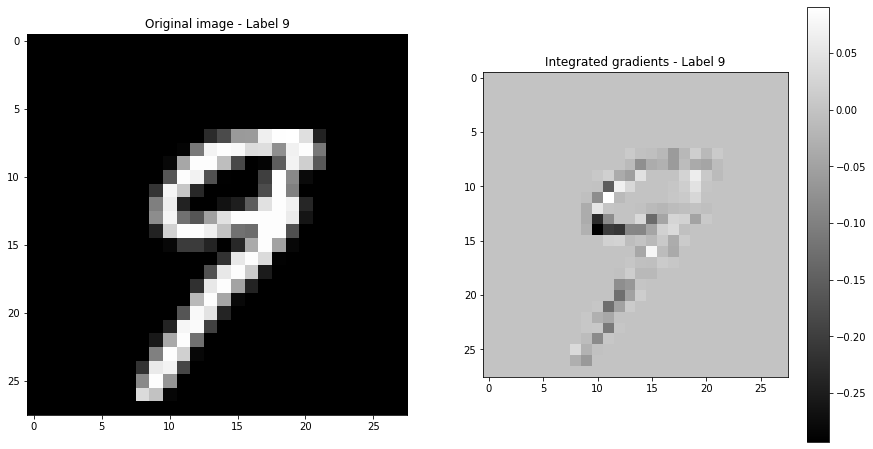

In [178]:
ig = Integrated_Gradients(images[10:11, ].detach(), labels[10:11])
int_grad_images.append(ig)

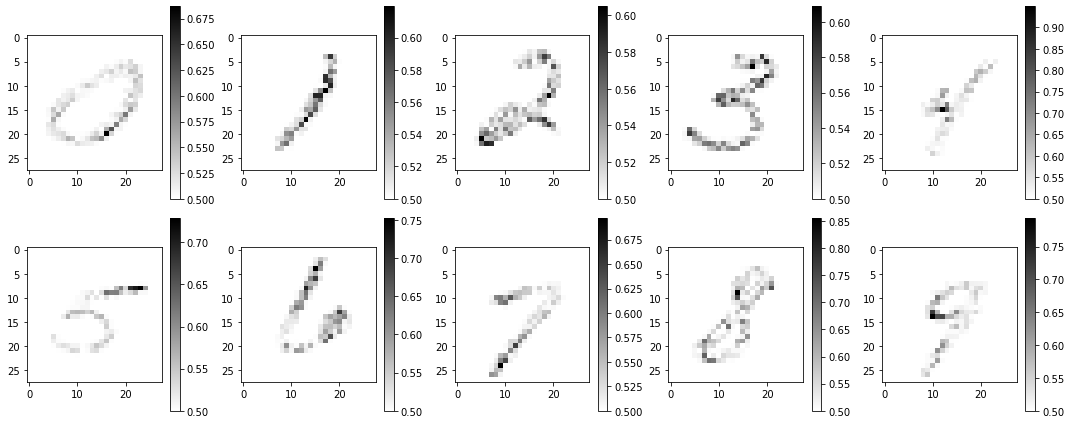

In [220]:
fig = plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(0.5+torch.squeeze(torch.abs(int_grad_images[i])).numpy(), cmap='gray_r')
#     plt.title('Integrated \\gradients - {}'.format(i))
    plt.colorbar(orientation="vertical")
plt.tight_layout()
plt.savefig('integrated_gradients.png')